In [7]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from matplotlib.colors import LogNorm
from astropy.table import join
import all_fctns
from astropy.wcs import WCS

Source_dir ="C:\\Users\\mspan\\OneDrive - The University of Sydney (Students)\\Honours\\"

"""Script to get a cutout of RACS-DR1 images of a given coordinate.
"""

import sys
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.casda import Casda  
from astroquery.utils.tap.core import TapPlus

# set these to your own values
OPAL_USER = "mspa4681@uni.sydney.edu.au"
SAVEDIR = Source_dir+ "Catalogues\\RACS_cutouts\\"

def racs_image_cutout(ra_deg, dec_deg, radius_arcmin, save_files=True, savedir=SAVEDIR):
    """Main function to get a cutout of RACS-DR1 images."""
    sys.argv = [0, ra_deg, dec_deg, radius_arcmin]

    # validate args
    if len(sys.argv) != 4:
        print("Need 3 args")
        print(f"Usage: python {sys.argv[0]} ra_deg dec_deg radius_arcmin")
        exit()

    # get args
    centre = SkyCoord(sys.argv[1], sys.argv[2], unit=(u.deg, u.deg))
    ra = centre.ra.degree
    dec = centre.dec.degree
    radius = float(sys.argv[3]) * u.arcmin

    # construct query for catalogued sources in RACS-DR1
    # ivoa.obscore is the table name
    # filters for RACS-DR1 fits images containing sources overlapping with
    #   the given coordinates
    query = "select * from ivoa.obscore "\
            "where filename LIKE 'RACS-DR1%' "\
            "AND filename LIKE '%A.fits' "\
        f"AND 1 = CONTAINS(POINT('ICRS',{ra},{dec}),s_region)"
    print(f"Query: {query}")
    # open connection to TAP service and run query
    casdatap = TapPlus(url="https://casda.csiro.au/casda_vo_tools/tap")
    job = casdatap.launch_job_async(query)
    table = job.get_results()

    print(table)

    # login to CASDA to be able to download images
    casda = Casda()
    casda.login(username=OPAL_USER, store_password=True)

    # request a cutout of the images returned by the query and download
    url_list = casda.cutout(table, coordinates=centre, radius=radius)
    print(url_list)
    if save_files:
        file_list = casda.download_files(url_list, savedir=savedir)
        

        print("Downloaded:")
        for file in file_list:
            print(f"  {file}")

In [8]:
with fits.open(Source_dir + "Catalogues\\Crossmatched\\SAMI_AGN_matches.fits") as SAMI_AGN_summary_hdul:
    SAMI_AGN_summary_table = Table(SAMI_AGN_summary_hdul[1].data)

RACS_matches_table = SAMI_AGN_summary_table[SAMI_AGN_summary_table["IS_RADIOSOURCE"] == 1]


with fits.open(Source_dir + "Catalogues\\ALL_SAMI_TARGETS.fits") as all_SAMI_targets_hdul:
    all_SAMI_target_table = Table(all_SAMI_targets_hdul[1].data)

all_SAMI_target_table.keep_columns(['CATID', 'RA_OBJ', 'DEC_OBJ'])
RACS_matches_table.keep_columns( ['CATID', 'IS_RADIOSOURCE','RACS_MATCHED_ID',
 'RACS_TOTALFLUX',
 'RACS_TOTALFLUX_ERR',
 'RACS_SOURCE_CLASSIFICATION'])


SAMI_target_RACS_matches = join(RACS_matches_table, all_SAMI_target_table, keys="CATID", join_type="left")

SAMI_target_RACS_matches

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\mspan\\OneDrive - The University of Sydney (Students)\\Honours\\Catalogues\\Crossmatched\\SAMI_AGN_matches.fits'

In [ ]:
index = np.argsort(SAMI_target_RACS_matches['RACS_TOTALFLUX'])
print("CATID of brightest RACS match:", SAMI_target_RACS_matches['CATID'][index])
test_object = SAMI_target_RACS_matches['RA_OBJ'][index], SAMI_target_RACS_matches['DEC_OBJ'][index]
print(f"Test object position: {test_object}")
racs_image_cutout(test_object[0], test_object[1], 1.0, save_files=True, savedir=SAVEDIR)

CATID of brightest RACS match:   CATID   
----------
    517278
    514212
9008500938
9044200188
    298862
    508138
    145729
     16026
9239900337
    491508
       ...
     64553
9403800001
    609396
9016800197
9008500001
9008500002
9403801368
9091700037
9388000001
9011900430
Length = 197 rows
Test object position: (<Column name='RA_OBJ' dtype='float64' length=197>
       131.6831757
      140.43013169
  10.7841373891386
         6.5992751
      222.14820513
      216.07367614
      185.93636698
      217.53450615
  329.161662920509
      212.16110627
      218.09195955
      129.58584589
               ...
215.61509409666667
      219.47224798
       356.9378052
      175.55091572
  18.8157541405619
  10.4602114396463
  10.4601582692453
       357.9030151
       355.3740845
       336.9769592
   14.395399865115, <Column name='DEC_OBJ' dtype='float64' length=197>
       2.53742151
       2.69086086
-9.82706081203952
      -33.2288246
       1.35415466
      -1.58419191
      -1.

ValueError: No table found

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    4 / number of array dimensions                     NAXIS1  =                   49                                                  NAXIS2  =                   49                                                  NAXIS3  =                    1                                                  NAXIS4  =                    1                                                  EQUINOX =        2000.00000000 / Mean equinox                                   RADESYS = 'ICRS    '           / Astrometric system                             CTYPE1  = 'RA---SIN'           / WCS projection type for this axis              CUNIT1  = 'deg     '           / Axis unit                                      CRVAL1  =   1.551516541667E+01 / World coordinate on this axis                  CRPIX1  =              -1586.5 / Referen

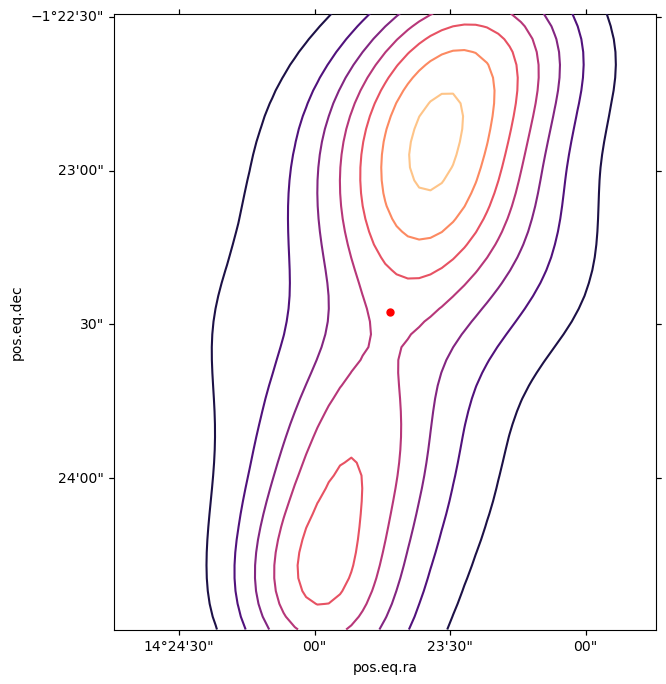

In [ ]:
with fits.open("C:\\Users\\mspan\\OneDrive - The University of Sydney (Students)\\Honours\\Catalogues\\RACS_cutouts\\cutout-936095-imagecube-71340.fits") as hdul:
    image_data = hdul[0].data.squeeze()    
    header = hdul[0].header

print(header)
# Slice the WCS to match 2D data
wcs_full = WCS(header)
wcs_2d = wcs_full.slice((2, 3))  # axes 2 and 3 correspond to y and x (Dec and RA)

height, width = 7, 8
fig, ax = plt.subplots(1, 1, figsize=(height, width), subplot_kw={'projection': wcs_2d})
fig.suptitle(f'', fontsize=10)

ax.contour(image_data, cmap='magma', transform=ax.get_transform(wcs_2d))
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)

ax.plot(test_object[0], test_object[1], 'ro', markersize=5, transform=ax.get_transform('world'), label='Test Object')

In [ ]:
hdul.info

<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x000002BE51235430>]>

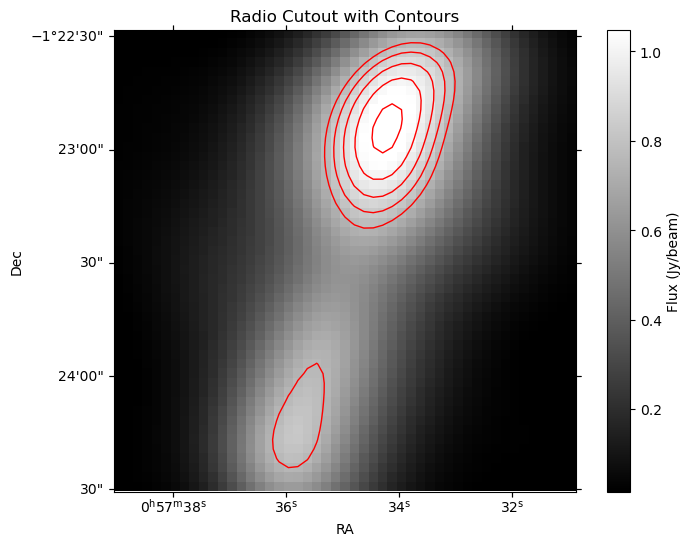

In [ ]:
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np

# Load the FITS file
with fits.open("C:\\Users\\mspan\\OneDrive - The University of Sydney (Students)\\Honours\\Catalogues\\RACS_cutouts\\cutout-936095-imagecube-71340.fits") as hdul:
    data = hdul[0].data  # Shape: (1, 1, 49, 49)
    header = hdul[0].header

# Extract 2D slice
image_2d = data[0, 0, :, :]  # Select the image

# Create 2D WCS object
wcs = WCS(header).slice((2, 3))

# Plot
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(projection=wcs)

# Show image
im = ax.imshow(image_2d, origin='lower', cmap='gray',
               vmin=np.percentile(image_2d, 5),
               vmax=np.percentile(image_2d, 99))

# Overplot contours
levels = np.linspace(np.percentile(image_2d, 90),
                     np.percentile(image_2d, 99.5), 5)
ax.contour(image_2d, levels=levels, colors='red',
           linewidths=1, transform=ax.get_transform(wcs))

# Axis labels and colorbar
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
plt.colorbar(im, ax=ax, label='Flux (Jy/beam)')
plt.title("Radio Cutout with Contours")
plt.show()

## Random Tests

In [ ]:
catid = 6821
import os
ifs_path = "\\import\\hortus1\\sami\\dr3_ingestion_v8\\data\\sami\\dr3\\ifs"
os.path.join(ifs_path, str(catid),str(catid)+'_spectrum_3-arcsec_blue_A.fits')

'\\import\\hortus1\\sami\\dr3_ingestion_v8\\data\\sami\\dr3\\ifs\\6821\\6821_spectrum_3-arcsec_blue_A.fits'

In [ ]:
# replace http with https
url =     'http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx?ra=174.1531666666667&dec=0.815861111111111&width=150&height=150&scale=0.49992'
url = url.replace("http://", "https://")

In [ ]:
# download SDSS RGB:
impix = 3 * 50
imsize = 3 * 0.4166*u.arcmin
cutoutbaseurl = 'https://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
query_string = urlencode(dict(ra=ra,dec=dec, 
                                    width=impix, height=impix, 
                                    scale=imsize.to(u.arcsec).value/impix))
url = cutoutbaseurl + '?' + query_string

# this downloads the image to your disk
urlretrieve(url, 'SDSS_cutout.jpg')
image = Image.open('SDSS_cutout.jpg')

ax21 = fig1.add_subplot(gs[1,0])
ax21.imshow(np.fliplr(image),origin='lower',interpolation='nearest')
ax21.text(0.05, 0.05,'SDSS',color='w',horizontalalignment='left',verticalalignment='center', transform=ax21.transAxes)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Authenticating mspa4681@uni.sydney.edu.au on CASDA ... [astroquery.casda.core]
INFO: Authentication successful! [astroquery.casda.core]


INFO: Found cached file C:\Users\mspan\.astropy\cache\astroquery\Casda\cutout-936645-imagecube-71340.fits with expected size 17280. [astroquery.query]


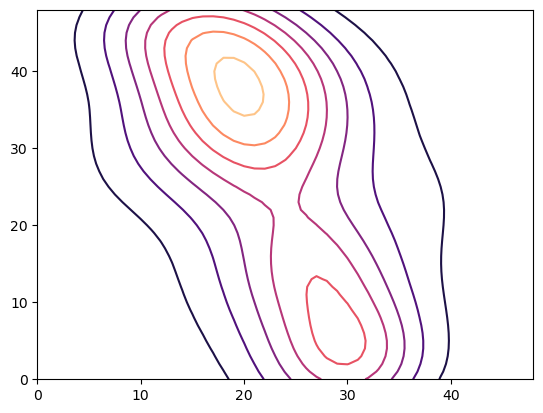

In [ ]:
from astroquery.casda import Casda  

OPAL_USER = "mspa4681@uni.sydney.edu.au"

ra = 14.395399865115
dec =-1.39100530699299

# download RACS Radio image cutout:
impix = 3 * 50
imsize = 3 * 0.4166*u.arcmin

# get args
centre = SkyCoord(ra, dec, unit=(u.deg, u.deg))
radius = float(sys.argv[3]) * u.arcmin


query = "select * from ivoa.obscore "\
        "where filename LIKE 'RACS-DR1%' "\
        "AND filename LIKE '%A.fits' "\
    f"AND 1 = CONTAINS(POINT('ICRS',{ra},{dec}),s_region)"
# open connection to TAP service and run query
casdatap = TapPlus(url="https://casda.csiro.au/casda_vo_tools/tap")
job = casdatap.launch_job_async(query)
table = job.get_results()

# login to CASDA to be able to download images
casda = Casda()
casda.login(username=OPAL_USER, store_password=True)

# request a cutout of the images returned by the query and download
url_list = casda.cutout(table, coordinates=centre, radius=radius) 
cutout_file = casda.download_files(url_list)

cutout_file = casda.download_files(url_list[:1])[0]
image = fits.open(cutout_file)[0].data.squeeze()

plt.contour(np.fliplr(image), cmap='magma')


INFO: Found cached file C:\Users\mspan\.astropy\cache\astroquery\Casda\cutout-936629-imagecube-71340.fits with expected size 17280. [astroquery.query]
C:\Users\mspan\.astropy\cache\astroquery\Casda\cutout-936629-imagecube-71340.fits


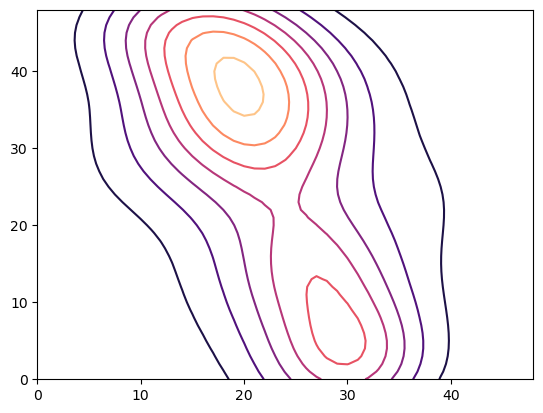

In [ ]:
table['access_url'][0]
url_list[:0]

cutout_file = casda.download_files(url_list[:1])[0]
print(cutout_file)
image = fits.open(cutout_file)[0].data.squeeze()

plt.contour(np.fliplr(image), cmap='magma')



INFO: Authenticating mspa4681@uni.sydney.edu.au on CASDA ... [astroquery.casda.core]
INFO: Authentication successful! [astroquery.casda.core]
INFO: Query finished. [astroquery.utils.tap.core]


['https://casda.csiro.au/download/web/4cd2bfd1-aef1-4b74-b13c-de0b5ecd7858/cutout-938123-imagecube-71340.fits.checksum', 'https://casda.csiro.au/download/web/4cd2bfd1-aef1-4b74-b13c-de0b5ecd7858/cutout-938123-imagecube-71340.fits']
C:\Users\mspan\.astropy\cache\astroquery\Casda\cutout-938123-imagecube-71340.fits


AttributeError: module 'astropy.io.fits' has no attribute 'close'

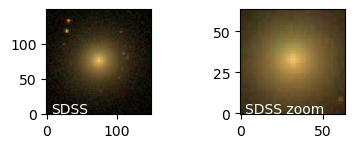

In [ ]:
from astroquery.casda import Casda  
from urllib.parse import urlencode
from urllib.request import urlretrieve
import pylab as py
from PIL import Image

OPAL_USER = "mspa4681@uni.sydney.edu.au"

isradio = True  # Set to True if you want to plot radio contours

if isradio:
    casda=Casda()
    casda.login(username=OPAL_USER, store_password=True)

ra = 14.395399865115
dec =-1.39100530699299

fig1 = py.figure(1,constrained_layout=True)
fig1.clf()
gs = fig1.add_gridspec(4, 4,wspace=0.3,hspace=0.3,top=0.95,bottom=0.1)


# download SDSS RGB:
impix = 3 * 50
imsize = 3 * 0.4166*u.arcmin
cutoutbaseurl = 'https://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
query_string = urlencode(dict(ra=ra,dec=dec, 
                                    width=impix, height=impix, 
                                    scale=imsize.to(u.arcsec).value/impix))
url = cutoutbaseurl + '?' + query_string

# this downloads the image to your disk
urlretrieve(url, 'SDSS_cutout.jpg')
image = Image.open('SDSS_cutout.jpg')

ax21 = fig1.add_subplot(gs[1,0])
ax21.imshow(np.fliplr(image),origin='lower',interpolation='nearest')
ax21.text(0.05, 0.05,'SDSS',color='w',horizontalalignment='left',verticalalignment='center', transform=ax21.transAxes)

# download SDSS RGB of same size as SAMI IFU:
impix = 50
#imsize = 0.25*u.arcmin
imsize = 0.4166*u.arcmin
cutoutbaseurl = 'https://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
query_string = urlencode(dict(ra=ra,dec=dec, 
                                    width=impix, height=impix, 
                                    scale=imsize.to(u.arcsec).value/impix))
url = cutoutbaseurl + '?' + query_string
# this downloads the image to your disk
urlretrieve(url, 'SDSS_cutout_small.jpg')
image = Image.open('SDSS_cutout_small.jpg')

ax22 = fig1.add_subplot(gs[1,1])
ax22.imshow(np.fliplr(image),origin='lower',interpolation='nearest')
ax22.text(0.05, 0.05,'SDSS zoom',color='w',horizontalalignment='left',verticalalignment='center', transform=ax22.transAxes)

#image.show()

# plot radio contours on SDSS images if isradio
if isradio:
    # download RACS Radio image cutout:
    impix = 3 * 50
    imsize = 3 * 0.4166*u.arcmin
    
    # get args
    centre = SkyCoord(ra, dec, unit=(u.deg, u.deg))
    
    
    query = "select * from ivoa.obscore "\
        "where filename LIKE 'RACS-DR1%' "\
        "AND filename LIKE '%A.fits' "\
        f"AND 1 = CONTAINS(POINT('ICRS',{ra},{dec}),s_region)"
    # open connection to TAP service and run query
    casdatap = TapPlus(url="https://casda.csiro.au/casda_vo_tools/tap")
    job = casdatap.launch_job_async(query)
    table = job.get_results()
    
    # request a cutout of the images returned by the query and download
    url_list = casda.cutout(table, coordinates=centre, radius=imsize) 
    print(url_list)
    cutout_file = casda.download_files(url_list[:2])[0].removesuffix('.checksum')
    print(cutout_file)
    image = fits.open(cutout_file)[0].data.squeeze()
    
    ax21.contour(np.fliplr(image), cmap='magma')
    
    
    # again for same size as SAMI IFU:
    impix = 50
    #imsize = 0.25*u.arcmin
    imsize = 0.4166*u.arcmin
    url_list = casda.cutout(table, coordinates=centre, radius=imsize) 
    
    cutout_file = casda.download_files(url_list[:2])[0].removesuffix('.checksum')

    image = fits.open(cutout_file)[0].data.squeeze()

    ax22.contour(np.fliplr(image), cmap='magma')

In [ ]:
fits.close()

AttributeError: module 'astropy.io.fits' has no attribute 'close'

INFO: Authenticating mspa4681@uni.sydney.edu.au on CASDA ... [astroquery.casda.core]
INFO: Authentication successful! [astroquery.casda.core]
INFO: Query finished. [astroquery.utils.tap.core]


['https://casda.csiro.au/download/web/551461eb-1f44-4b0c-88e6-1d9eac6a5c54/cutout-938148-imagecube-71340.fits', 'https://casda.csiro.au/download/web/551461eb-1f44-4b0c-88e6-1d9eac6a5c54/cutout-938148-imagecube-71340.fits.checksum']
C:\Users\mspan\.astropy\cache\astroquery\Casda\cutout-938148-imagecube-71340.fits


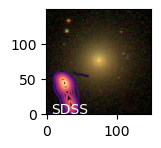

In [ ]:
from astroquery.casda import Casda  
from urllib.parse import urlencode
from urllib.request import urlretrieve
import pylab as py
from PIL import Image

OPAL_USER = "mspa4681@uni.sydney.edu.au"

isradio = True  # Set to True if you want to plot radio contours

if isradio:
    casda=Casda()
    casda.login(username=OPAL_USER, store_password=True)

ra = 14.395399865115
dec =-1.39100530699299

fig1 = py.figure(1,constrained_layout=True)
fig1.clf()
gs = fig1.add_gridspec(4, 4,wspace=0.3,hspace=0.3,top=0.95,bottom=0.1)


# download SDSS RGB:
impix = 3 * 50
imsize = 3 * 0.4166*u.arcmin
cutoutbaseurl = 'https://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
query_string = urlencode(dict(ra=ra,dec=dec, 
                                    width=impix, height=impix, 
                                    scale=imsize.to(u.arcsec).value/impix))
url = cutoutbaseurl + '?' + query_string

# this downloads the image to your disk
urlretrieve(url, 'SDSS_cutout.jpg')
image = Image.open('SDSS_cutout.jpg')

ax21 = fig1.add_subplot(gs[1,0])
ax21.imshow(np.fliplr(image),origin='lower',interpolation='nearest')
ax21.text(0.05, 0.05,'SDSS',color='w',horizontalalignment='left',verticalalignment='center', transform=ax21.transAxes)

# # download SDSS RGB of same size as SAMI IFU:
# impix = 50
# #imsize = 0.25*u.arcmin
# imsize = 0.4166*u.arcmin
# cutoutbaseurl = 'https://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
# query_string = urlencode(dict(ra=ra,dec=dec, 
#                                     width=impix, height=impix, 
#                                     scale=imsize.to(u.arcsec).value/impix))
# url = cutoutbaseurl + '?' + query_string
# # this downloads the image to your disk
# urlretrieve(url, 'SDSS_cutout_small.jpg')
# image = Image.open('SDSS_cutout_small.jpg')

# ax22 = fig1.add_subplot(gs[1,1])
# ax22.imshow(np.fliplr(image),origin='lower',interpolation='nearest')
# ax22.text(0.05, 0.05,'SDSS zoom',color='w',horizontalalignment='left',verticalalignment='center', transform=ax22.transAxes)

# #image.show()

# plot radio contours on SDSS images if isradio
if isradio:
    # download RACS Radio image cutout:
    impix = 3 * 50
    imsize = 3 * 0.4166*u.arcmin
    
    # get args
    centre = SkyCoord(ra, dec, unit=(u.deg, u.deg))
    
    
    query = "select * from ivoa.obscore "\
        "where filename LIKE 'RACS-DR1%' "\
        "AND filename LIKE '%A.fits' "\
        f"AND 1 = CONTAINS(POINT('ICRS',{ra},{dec}),s_region)"
    # open connection to TAP service and run query
    casdatap = TapPlus(url="https://casda.csiro.au/casda_vo_tools/tap")
    job = casdatap.launch_job_async(query)
    table = job.get_results()
    
    # request a cutout of the images returned by the query and download
    url_list = casda.cutout(table, coordinates=centre, radius=imsize) 
    print(url_list)
    cutout_file = casda.download_files(url_list[:2])[0].removesuffix('.checksum')
    print(cutout_file)
    image = fits.open(cutout_file)[0].data.squeeze()
    
    ax21.contour(np.fliplr(image), cmap='magma')
    
    
    # # again for same size as SAMI IFU:
    # impix = 50
    # #imsize = 0.25*u.arcmin
    # imsize = 0.4166*u.arcmin
    # url_list = casda.cutout(table, coordinates=centre, radius=imsize) 
    
    # cutout_file = casda.download_files(url_list[:2])[0].removesuffix('.checksum')

    # image = fits.open(cutout_file)[0].data.squeeze()

    # ax22.contour(np.fliplr(image), cmap='magma')

INFO: Authenticating mspa4681@uni.sydney.edu.au on CASDA ... [astroquery.casda.core]


ERROR: Authentication failed [astroquery.casda.core]


NameError: name 'cutout_file' is not defined

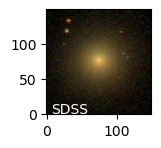

In [ ]:
from astroquery.casda import Casda  
from urllib.parse import urlencode
from urllib.request import urlretrieve
import pylab as py
from PIL import Image

OPAL_USER = "mspa4681@uni.sydney.edu.au"

isradio = True  # Set to True if you want to plot radio contours

if isradio:
    casda=Casda()
    casda.login(username=OPAL_USER, store_password=True)

ra = 14.395399865115
dec =-1.39100530699299

fig1 = py.figure(1,constrained_layout=True)
fig1.clf()
gs = fig1.add_gridspec(4, 4,wspace=0.3,hspace=0.3,top=0.95,bottom=0.1)


# download SDSS RGB:
impix = 3 * 50
imsize = 3 * 0.4166*u.arcmin
cutoutbaseurl = 'https://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
query_string = urlencode(dict(ra=ra,dec=dec, 
                                    width=impix, height=impix, 
                                    scale=imsize.to(u.arcsec).value/impix))
url = cutoutbaseurl + '?' + query_string

# this downloads the image to your disk
urlretrieve(url, 'SDSS_cutout.jpg')
image = Image.open('SDSS_cutout.jpg')

ax21 = fig1.add_subplot(gs[1,0])
ax21.imshow(np.fliplr(image),origin='lower',interpolation='nearest')
ax21.text(0.05, 0.05,'SDSS',color='w',horizontalalignment='left',verticalalignment='center', transform=ax21.transAxes)

# # download SDSS RGB of same size as SAMI IFU:
# impix = 50
# #imsize = 0.25*u.arcmin
# imsize = 0.4166*u.arcmin
# cutoutbaseurl = 'https://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
# query_string = urlencode(dict(ra=ra,dec=dec, 
#                                     width=impix, height=impix, 
#                                     scale=imsize.to(u.arcsec).value/impix))
# url = cutoutbaseurl + '?' + query_string
# # this downloads the image to your disk
# urlretrieve(url, 'SDSS_cutout_small.jpg')
# image = Image.open('SDSS_cutout_small.jpg')

# ax22 = fig1.add_subplot(gs[1,1])
# ax22.imshow(np.fliplr(image),origin='lower',interpolation='nearest')
# ax22.text(0.05, 0.05,'SDSS zoom',color='w',horizontalalignment='left',verticalalignment='center', transform=ax22.transAxes)

# #image.show()

# plot radio contours on SDSS images if isradio
if isradio:
    # download RACS Radio image cutout:
    impix = 3 * 50
    imsize = 3 * 0.4166*u.arcmin
    
    # get args
    centre = SkyCoord(ra, dec, unit=(u.deg, u.deg))
    
    
    # query = "select * from ivoa.obscore "\
    #     "where filename LIKE 'RACS-DR1%' "\
    #     "AND filename LIKE '%A.fits' "\
    #     f"AND 1 = CONTAINS(POINT('ICRS',{ra},{dec}),s_region)"
    # # open connection to TAP service and run query
    # casdatap = TapPlus(url="https://casda.csiro.au/casda_vo_tools/tap")
    # job = casdatap.launch_job_async(query)
    # table = job.get_results()
    
    # # request a cutout of the images returned by the query and download
    # url_list = casda.cutout(table, coordinates=centre, radius=imsize) 
    # print(url_list)
    # cutout_file = casda.download_files(url_list[:2])[0].removesuffix('.checksum')
    # print(cutout_file)
    image = fits.open(cutout_file)[0].data.squeeze()
    
    ax21.contour(np.fliplr(image), colors='white', linewidths=0.5, alpha=0.25, extent=(0,impix, 0, impix))
    
    
    # # again for same size as SAMI IFU:
    # impix = 50
    # #imsize = 0.25*u.arcmin
    # imsize = 0.4166*u.arcmin
    # url_list = casda.cutout(table, coordinates=centre, radius=imsize) 
    
    # cutout_file = casda.download_files(url_list[:2])[0].removesuffix('.checksum')

    # image = fits.open(cutout_file)[0].data.squeeze()

    # ax22.contour(np.fliplr(image), cmap='magma')

INFO: Authenticating mspa4681@uni.sydney.edu.au on CASDA ... [astroquery.casda.core]


ERROR: Authentication failed [astroquery.casda.core]


HTTPError: Service Unavailable

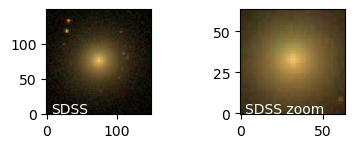

In [ ]:
from astroquery.casda import Casda  
from urllib.parse import urlencode
from urllib.request import urlretrieve
import pylab as py
from PIL import Image
import glob

OPAL_USER = "mspa4681@uni.sydney.edu.au"

isradio = True  # Set to True if you want to plot radio contours

if isradio:
    casda=Casda()
    casda.login(username=OPAL_USER, store_password=True)

ra = 14.395399865115
dec =-1.39100530699299

fig1 = py.figure(1,constrained_layout=True)
fig1.clf()
gs = fig1.add_gridspec(4, 4,wspace=0.3,hspace=0.3,top=0.95,bottom=0.1)


# download SDSS RGB:
impix = 3 * 50
imsize = 3 * 0.4166*u.arcmin
cutoutbaseurl = 'https://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
query_string = urlencode(dict(ra=ra,dec=dec, 
                                    width=impix, height=impix, 
                                    scale=imsize.to(u.arcsec).value/impix))
url = cutoutbaseurl + '?' + query_string

# this downloads the image to your disk
urlretrieve(url, 'SDSS_cutout.jpg')
image = Image.open('SDSS_cutout.jpg')

ax21 = fig1.add_subplot(gs[1,0])
ax21.imshow(np.fliplr(image),origin='lower',interpolation='nearest')
ax21.text(0.05, 0.05,'SDSS',color='w',horizontalalignment='left',verticalalignment='center', transform=ax21.transAxes)

# download SDSS RGB of same size as SAMI IFU:
impix = 50
#imsize = 0.25*u.arcmin
imsize = 0.4166*u.arcmin
cutoutbaseurl = 'https://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
query_string = urlencode(dict(ra=ra,dec=dec, 
                                    width=impix, height=impix, 
                                    scale=imsize.to(u.arcsec).value/impix))
url = cutoutbaseurl + '?' + query_string
# this downloads the image to your disk
urlretrieve(url, 'SDSS_cutout_small.jpg')
image = Image.open('SDSS_cutout_small.jpg')

ax22 = fig1.add_subplot(gs[1,1])
ax22.imshow(np.fliplr(image),origin='lower',interpolation='nearest')
ax22.text(0.05, 0.05,'SDSS zoom',color='w',horizontalalignment='left',verticalalignment='center', transform=ax22.transAxes)

#image.show()

# plot radio contours on SDSS images if isradio
if isradio:
    # download RACS Radio image cutout:
    impix = 3 * 50
    imsize = 3 * 0.4166*u.arcmin
    
    # get args
    centre = SkyCoord(ra, dec, unit=(u.deg, u.deg))
    
def get_racs_image_cutout(ra, dec, imsize, casda=None, save_dir="", redo_cutout=False):
    """Saves a cutout of RACS-DR1 images at the given coordinate, with the given size."""
    
    # first check if logged in to CASDA
    if casda is None:
        casda = Casda()
        casda.login(username=OPAL_USER, store_password=False)


    save_str = f"{save_dir}RACS_DR1-cutout-{ra}-{dec}-{imsize}.fits"

    #check if file already exists
    if glob.glob(save_str) and not redo_cutout:
        print(f"RACS cutout found: {save_str}")
        return save_str
    
    # if not, get the image cutout
    query = "select * from ivoa.obscore "\
        "where filename LIKE 'RACS-DR1%' "\
        "AND filename LIKE '%A.fits' "\
        f"AND 1 = CONTAINS(POINT('ICRS',{ra},{dec}),s_region)"
    # open connection to TAP service and run query
    casdatap = TapPlus(url="https://casda.csiro.au/casda_vo_tools/tap")
    job = casdatap.launch_job_async(query)
    table = job.get_results()
    
    # request a cutout of the images returned by the query and download
    url_list = casda.cutout(table, coordinates=centre, radius=imsize) 

    #only care about the first url but will have to remove the .checksum
    url_relevant = url_list[0].removesuffix('.checksum')
    cutout_file = casda.download_files([url_relevant])[0]

    #rename the saved file and replace the old one if it exists
    if os.path.exists(save_str):
        os.remove(save_str)
    
    os.rename(cutout_file, save_str)
    print(f"New RACS cutout saved: {save_str}")
    return save_str

    image = fits.open(cutout_file)[0].data.squeeze()
    
    ax21.contour(np.fliplr(image), colors='white', linewidths=0.5, alpha=0.25, extent=(0,impix, 0, impix))


    # again for same size as SAMI IFU:
    impix = 65
    #imsize = 0.25*u.arcmin
    imsize = 0.4166*u.arcmin
    url_list = casda.cutout(table, coordinates=centre, radius=imsize) 
    
    #only care about the first url but will have to remove the .checksum
    url_relevant = url_list[0].removesuffix('.checksum')
    cutout_file = casda.download_files([url_relevant])[0]

    image = fits.open(cutout_file)[0].data.squeeze()
    
    ax22.contour(np.fliplr(image), colors='white', linewidths=0.5, alpha=0.25, extent=(0,impix, 0, impix))



In [ ]:
import os

ra=1
dec=1
imsize = 0.4166*u.arcmin

save_str = f"RACS_DR1-cutout-{ra}-{dec}-{imsize}.fits"
save_dir = "racs_cutouts\\"

cutout_file = 'test.fits'
fd = os.open(save_dir+cutout_file, os.O_CREAT)
os.close(fd)

if os.path.exists(save_dir+save_str):
    os.remove(save_dir+save_str)

os.rename(save_dir+cutout_file, save_dir+save_str)


In [ ]:
os.getcwd()

'c:\\Users\\mspan\\OneDrive - The University of Sydney (Students)\\Honours\\Code'

# FIRST cutout testing

In [ ]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy.table import join
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.coordinates import SkyCoord
from scipy.optimize import linear_sum_assignment
import all_fctns
from astroquery.image_cutouts.first import First
from matplotlib.colors import LogNorm


def refresh_module():
    import importlib
    import all_fctns
    importlib.reload(all_fctns)

Source_dir ="C:\\Users\\mspan\\OneDrive - The University of Sydney (Students)\\Honours\\Honours Project\\"
catalogue_filepath = Source_dir+"Catalogues\\"
git_summary_table_filepath = Source_dir+"sami_tools_smc_mspa4681\\shared_catalogues\\"

with fits.open(git_summary_table_filepath+ "SAMI_AGN_matches.fits") as SAMI_AGN_matches_hdul:
    Summary_table_hdu = Table(SAMI_AGN_matches_hdul[1].data)

all_SAMI_target_table = all_fctns.get_all_SAMI_targets_catalogue(catalogue_filepath)


CATID of brightest FIRST match:   CATID   
----------
9016800093
9016800234
    514214
    537226
    569555
    371789
9016800167
    301382
     69740
    386892
       ...
    279932
     41059
    600743
     77967
    205085
    376990
    372123
9016800197
    238211
9011900547
Length = 107 rows
72.48


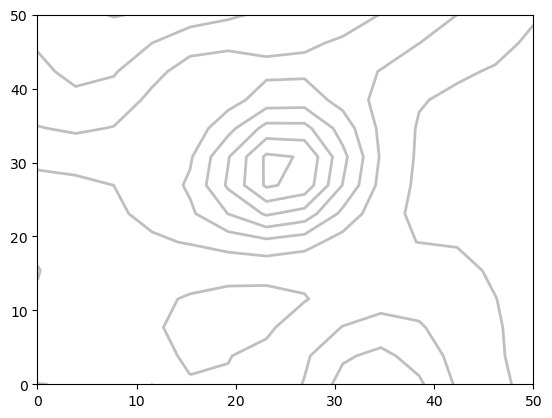

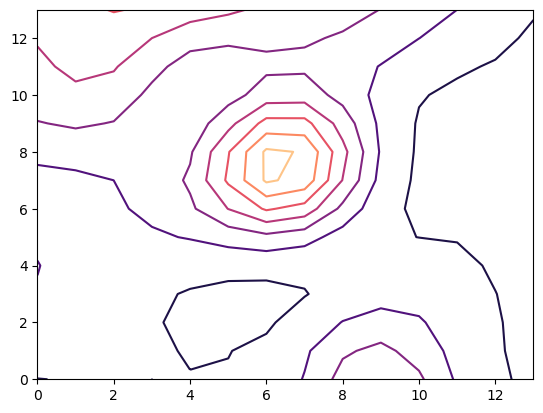

In [ ]:
# index = np.argsort(SAMI_target_RACS_matches['RACS_TOTALFLUX'])
# print("CATID of brightest RACS match:", SAMI_target_RACS_matches['CATID'][index])
# test_object = SAMI_target_RACS_matches['RA_OBJ'][index], SAMI_target_RACS_matches['DEC_OBJ'][index]
# print(f"Test object position: {test_object}")
# racs_image_cutout(test_object[0], test_object[1], 1.0, save_files=True, savedir=SAVEDIR)
from matplotlib.colors import LogNorm

LARGESS_mask = Summary_table_hdu['IS_LARGESSSOURCE'] == True

index = np.argsort(Summary_table_hdu[LARGESS_mask]['FIRST_TOTALFLUX'])
print("CATID of brightest FIRST match:", Summary_table_hdu[LARGESS_mask]['CATID'][index])

test_CATID = Summary_table_hdu[LARGESS_mask]['CATID'][index][0]
print(np.max(Summary_table_hdu[LARGESS_mask]['FIRST_TOTALFLUX']))

test_CATID = 9239900004

test_CATID_target_row = all_SAMI_target_table[all_SAMI_target_table['CATID'] == test_CATID]

test_object = test_CATID_target_row['RA_OBJ'][0], test_CATID_target_row['DEC_OBJ'][0]

test_object = 14.395399865115, -1.39100530699299


impix = 50
imsize = 0.4166*u.arcmin
image = First.get_images(SkyCoord(test_object[0]*u.deg, test_object[1]*u.deg,
                                               frame='icrs'), image_size =imsize)
image

test_im = image[0].data.squeeze()

# plt.imshow(test_im)

# image = fits.open(cutout_file)[0].data.squeeze()
# plt.imshow(np.fliplr(test_im), extent=(0,impix, 0, impix), norm=LogNorm())
plt.contour(np.fliplr(test_im), colors='black', linewidths=2, alpha=0.25, extent=(0,impix, 0, impix))
plt.show()

plt.contour(np.fliplr(test_im), cmap='magma')


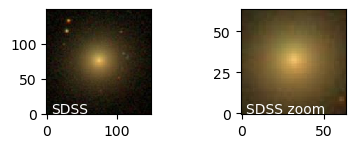

In [ ]:
from astroquery.casda import Casda  
from urllib.parse import urlencode
from urllib.request import urlretrieve
import pylab as py
from PIL import Image
from astroquery.image_cutouts.first import First
from astropy import coordinates
from astropy import units as u
import numpy as np
OPAL_USER = "mspa4681@uni.sydney.edu.au"


isradio = True # Set to True if you want to plot radio contours
isRACS = False 
isFIRST = True

if isRACS:
    casda=Casda()
    casda.login(username=OPAL_USER, store_password=True)

ra = 14.395399865115
dec =-1.39100530699299

fig1 = py.figure(1,constrained_layout=True)
fig1.clf()
gs = fig1.add_gridspec(4, 4,wspace=0.3,hspace=0.3,top=0.95,bottom=0.1)


# download SDSS RGB:
impix = 3 * 50
imsize = 3 * 0.4166*u.arcmin
cutoutbaseurl = 'https://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
query_string = urlencode(dict(ra=ra,dec=dec, 
                                    width=impix, height=impix, 
                                    scale=imsize.to(u.arcsec).value/impix))
url = cutoutbaseurl + '?' + query_string

# this downloads the image to your disk
urlretrieve(url, 'SDSS_cutout.jpg')
image = Image.open('SDSS_cutout.jpg')

ax21 = fig1.add_subplot(gs[1,0])
ax21.imshow(np.fliplr(image),origin='lower',interpolation='nearest')
ax21.text(0.05, 0.05,'SDSS',color='w',horizontalalignment='left',verticalalignment='center', transform=ax21.transAxes)

# download SDSS RGB of same size as SAMI IFU:
impix = 50
#imsize = 0.25*u.arcmin
imsize = 0.4166*u.arcmin
cutoutbaseurl = 'https://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
query_string = urlencode(dict(ra=ra,dec=dec, 
                                    width=impix, height=impix, 
                                    scale=imsize.to(u.arcsec).value/impix))
url = cutoutbaseurl + '?' + query_string
# this downloads the image to your disk
urlretrieve(url, 'SDSS_cutout_small.jpg')
image = Image.open('SDSS_cutout_small.jpg')

ax22 = fig1.add_subplot(gs[1,1])
ax22.imshow(np.fliplr(image),origin='lower',interpolation='nearest')
ax22.text(0.05, 0.05,'SDSS zoom',color='w',horizontalalignment='left',verticalalignment='center', transform=ax22.transAxes)

#image.show()

# plot radio contours on SDSS images if isradio
if isRACS:
    # download RACS Radio image cutout:
    impix = 3 * 50
    imsize = 3 * 0.4166*u.arcmin
    
    # get args
    centre = SkyCoord(ra, dec, unit=(u.deg, u.deg))
    
    if isRACS:
        query = "select * from ivoa.obscore "\
            "where filename LIKE 'RACS-DR1%' "\
            "AND filename LIKE '%A.fits' "\
            f"AND 1 = CONTAINS(POINT('ICRS',{ra},{dec}),s_region)"
        # open connection to TAP service and run query
        casdatap = TapPlus(url="https://casda.csiro.au/casda_vo_tools/tap")
        job = casdatap.launch_job_async(query)
        table = job.get_results()
    
        # request a cutout of the images returned by the query and download
        url_list = casda.cutout(table, coordinates=centre, radius=imsize) 
        print(url_list)
        cutout_file = casda.download_files(url_list[:2])[0].removesuffix('.checksum')
        print(cutout_file)
        image = fits.open(cutout_file)[0].data.squeeze()
        
        ax21.contour(np.fliplr(image), cmap='magma')
        
        
        # again for same size as SAMI IFU:
        impix = 50
        #imsize = 0.25*u.arcmin
        imsize = 0.4166*u.arcmin
        url_list = casda.cutout(table, coordinates=centre, radius=imsize) 
        
        cutout_file = casda.download_files(url_list[:2])[0].removesuffix('.checksum')

        image = fits.open(cutout_file)[0].data.squeeze()

        ax22.contour(np.fliplr(image), cmap='magma')


    if isFIRST:
        impix = 3* 50
        imsize =3* 0.4166*u.arcmin

        image = First.get_images(SkyCoord(test_object[0]*u.deg, test_object[1]*u.deg,
                                                    frame='icrs'), image_size =imsize)
        test_im = image[0].data.squeeze()
        # plt.imshow(test_im)
        # image = fits.open(cutout_file)[0].data.squeeze()
        ax21.contour(np.fliplr(test_im), colors='white', linewidths=2, alpha=0.25, extent=(0,impix, 0, impix))


        impix = 50
        imsize = 0.4166*u.arcmin

        image = First.get_images(SkyCoord(test_object[0]*u.deg, test_object[1]*u.deg,
                                                    frame='icrs'), image_size =imsize)
        test_im = image[0].data.squeeze()
        # plt.imshow(test_im)
        # image = fits.open(cutout_file)[0].data.squeeze()
        ax22.contour(np.fliplr(test_im), colors='white', linewidths=2, alpha=0.25, extent=(0,impix, 0, impix))
        print(1)


plt.show()
                

<SkyCoord (ICRS): (ra, dec) in deg
    (14.39539987, -1.39100531)>
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Authenticating mspa4681@uni.sydney.edu.au on CASDA ... [astroquery.casda.core]
INFO: Authentication successful! [astroquery.casda.core]


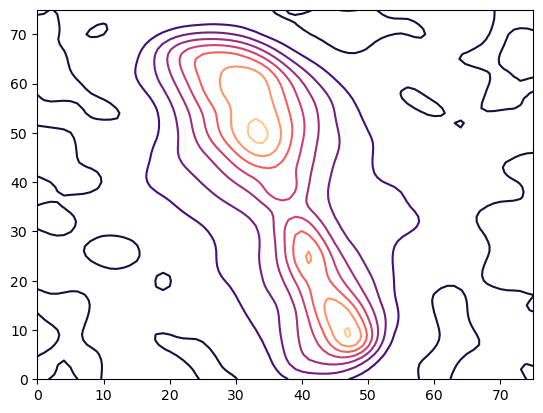

In [ ]:
from astropy import coordinates, units as u, wcs

from astropy.coordinates import SkyCoord

from astroquery.casda import Casda 

from astroquery.utils.tap.core import TapPlus

from astroquery.utils.tap.core import Tap

import getpass

#set TAP to the CASDA service 

casdatap = TapPlus(url="https://casda.csiro.au/casda_vo_tools/tap")


ra = 14.395399865115
dec =-1.39100530699299

centre = SkyCoord(ra, dec, unit=(u.deg, u.deg))

print(centre) 

#need to set the following to the centre coords


#Query for RACS-Mid, we know the filename

query = "select * from ivoa.obscore where filename LIKE 'RACS-MID1________.fits' AND 1 = CONTAINS(POINT('ICRS',"+ str(ra) + ","+ str(dec) + "),s_region)"

#do ADQL command on obscore to return list of images

job = casdatap.launch_job_async(query)

r = job.get_results()

OPAL_USER = 'mspa4681@uni.sydney.edu.au'

password = getpass.getpass(str("Enter your OPAL password: "))

casda=Casda()
casda.login(username=OPAL_USER, store_password=True)

#make cutout
impix = 3 * 50
imsize = 3 * 0.4166*u.arcmin

url_list = casda.cutout(r, coordinates=centre, radius=imsize)

#download cutout

filelist = casda.download_files(url_list, savedir='racs_cutouts\\')

image = fits.open(filelist[0])[0].data.squeeze()
        
plt.contour(np.fliplr(image), cmap='magma')

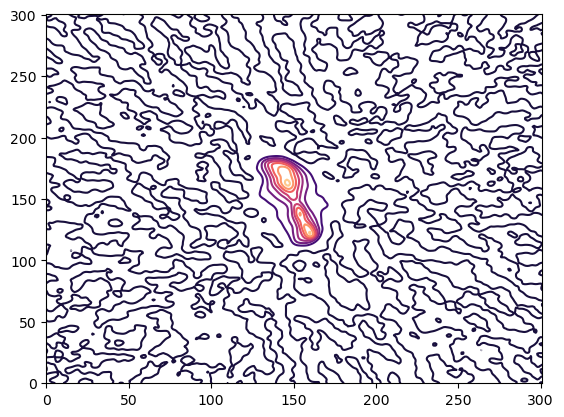